In [1]:
import numpy as np
from scipy.optimize import differential_evolution
from scipy.optimize import linprog
from scipy.ndimage import distance_transform_edt
import SimpleITK as sitk
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from mpl_toolkits.mplot3d import Axes3D
import random

np.random.seed(42)

### Loading Data

In [2]:
# Load the segmentation data
segmentation_map_file_path = "OASIS-TRT-20-10_DKT31_CMA_labels_in_MNI152.nii.gz"
segmentation_map_image = sitk.ReadImage(segmentation_map_file_path)
segmentation_map_data = sitk.GetArrayFromImage(segmentation_map_image) # np.unique(segmentation_map_data) == [0,4,5,6,7,10,11,12,13,14,15,16,...,2030,2031,2034,2035]

# Load the label map of brain
brain_mask_file_path = "Segmentation_8-BrainLabelMap-label_1.nrrd"
brain_mask_image = sitk.ReadImage(brain_mask_file_path)
brain_mask_data = sitk.GetArrayFromImage(brain_mask_image) # np.unique(brain_mask_data) == [0,1]

def assign_random_importance(segmentation_map_data):
    # Get the unique class labels in the segmentation map
    unique_classes = np.unique(segmentation_map_data)
    
    # Remove the background (assuming it is labeled as 0)
    unique_classes = unique_classes[unique_classes != 0]
    
    # Assign a random importance value to each class
    # We can use np.random.rand to generate random values between 0 and 1, or np.random.uniform to specify a range
    importance_map = {}
    for cls in unique_classes:
        importance_map[cls] = np.random.uniform(0, 1)  # Random importance between 0 and 1
    
    return importance_map

# Assign random importance to each class
importance_map = assign_random_importance(segmentation_map_data)

### Utility Functions

In [3]:
# def add_tumor_to_data(data1, label_map, radius=3):
#     # Find all brain coordinates (label == 1)
#     brain_coords = np.argwhere(label_map == 1)  # Assuming 1 represents brain tissue in your segmentation
    
#     # Randomly select a point as the tumor center
#     tumor_center = brain_coords[np.random.randint(len(brain_coords))]
    
#     # Get the shape of the data matrix
#     shape = data1.shape
    
#     # Add the tumor as a sphere around the tumor center
#     for dz in range(-radius, radius + 1):
#         for dy in range(-radius, radius + 1):
#             for dx in range(-radius, radius + 1):
#                 if dz**2 + dy**2 + dx**2 <= radius**2:  # Check if within the sphere
#                     z, y, x = tumor_center + np.array([dz, dy, dx])
#                     if (
#                         0 <= z < shape[0] and
#                         0 <= y < shape[1] and
#                         0 <= x < shape[2] and
#                         label_map[z, y, x] == 1  # Ensure the tumor stays within brain tissue
#                     ):
#                         data1[z, y, x] = 999  # Assign label 999 for the tumor

#     return data1, tumor_center

# def create_two_sided_beams(tumor_center, num_beams):
#     """
#     Generate two-sided beams originating from the tumor center.
#     Each beam has a direction vector and its opposite.
#     """
#     beams = []

#     # Generate points on a sphere using the Fibonacci sphere method
#     phi = (1 + np.sqrt(5)) / 2  # Golden ratio
#     for i in range(num_beams):
#         z = 1 - (2 * i + 1) / num_beams  # z-coordinates spaced evenly
#         radius = np.sqrt(1 - z**2)  # Radius of the circle at height z
#         theta = 2 * np.pi * i / phi  # Angle using the golden ratio
#         x = radius * np.cos(theta)
#         y = radius * np.sin(theta)

#         direction = np.array([x, y, z])

#         # Each beam has two directions: original and opposite
#         beams.append({"start": tumor_center, "direction": direction})
#         beams.append({"start": tumor_center, "direction": -direction})  # Opposite direction

#     return beams

# def calculate_voxels_affected(beams, data_shape, beam_radius):
#     """
#     Determine which voxels are touched by each beam, given a specific beam radius.
#     """
#     affected_voxels = defaultdict(list)
#     for beam_index, beam in enumerate(beams):
#         start = np.array(beam["start"])
#         direction = np.array(beam["direction"])
        
#         # Move along the beam direction up to the bounds of the 3D space
#         for t in range(-beam_radius, beam_radius + 1):
#             position = start + t * direction
#             voxel = np.round(position).astype(int)  # Convert to voxel indices
            
#             # Ensure voxel is within bounds
#             if all(0 <= voxel[i] < data_shape[i] for i in range(3)):
#                 affected_voxels[beam_index].append(tuple(voxel))
#     return affected_voxels

# def compute_intensity(weights, affected_voxels, data_shape):
#     """
#     Compute the intensity experienced by each voxel based on the beam weights.
#     """
#     intensity_matrix = np.zeros(data_shape)
#     for beam_index, weight in enumerate(weights):
#         for voxel in affected_voxels[beam_index]:
#             z, y, x = voxel

#             intensity = weight  
#             intensity_matrix[z, y, x] += intensity
#     return intensity_matrix

# def calculate_total_tumor_intensity(intensity_matrix, data_with_tumor, tumor_label=999):
#     """
#     Calculate the total intensity delivered to tumor cells.
    
#     Args:
#         intensity_matrix: 3D array of intensity values.
#         data_with_tumor: 3D array with tumor labels (999 for tumor).
#         tumor_label: The label value representing tumor cells (default 999).
    
#     Returns:
#         Total intensity delivered to the tumor cells.
#     """
#     # Create a mask for tumor voxels
#     tumor_mask = (data_with_tumor == tumor_label)
    
#     # Sum the intensities in the tumor region
#     total_tumor_intensity = np.sum(intensity_matrix[tumor_mask])
    
#     return total_tumor_intensity

# # Step 1: Calculate the dose contributions
# def calculate_doses(beams, tumor_mask, normal_mask, intensity_matrix, num_beams, affected_voxels):
#     beam_doses_to_tumor = np.zeros(num_beams)
#     beam_doses_to_normal = np.zeros(num_beams)
#     new_intensity_matrix = np.zeros_like(intensity_matrix)

#     for beam_index, beam in enumerate(beams):
#         for voxel in affected_voxels[beam_index]:
#             z, y, x = voxel

#             intensity = intensity_matrix[z,y,x]
#             new_intensity_matrix[z, y, x] += intensity

#             if tumor_mask[z, y, x]:
#                 beam_doses_to_tumor[beam_index] += intensity
#             elif normal_mask[z, y, x]:
#                 beam_doses_to_normal[beam_index] += intensity

#     return beam_doses_to_tumor, beam_doses_to_normal, new_intensity_matrix

In [4]:
def add_tumor_to_data(_segmentation_map_data: np.ndarray, _brain_mask_data: np.ndarray, tumor_size: int = None):
    # Find all brain coordinates (label == 1)
    brain_coords = np.argwhere(_brain_mask_data == 1)  # Assuming 1 represents brain tissue in your segmentation
    
    # Randomly select a point as the tumor center
    tumor_center = tuple(brain_coords[np.random.randint(len(brain_coords))])
    
    # Get the shape of the data matrix
    shape = _segmentation_map_data.shape
    
    # Initialize tumor voxels set and add the center voxel
    tumor_voxels = set()
    tumor_voxels.add(tumor_center)
    _segmentation_map_data[tumor_center] = 999  # Assign label 999 for the tumor

    # Maintain a set of valid neighbors
    valid_neighbors = set()
    
    # All 26 directions (adjacent + diagonal neighbors)
    directions = [
        (-1, 0, 0), (1, 0, 0),  # x-axis neighbors
        (0, -1, 0), (0, 1, 0),  # y-axis neighbors
        (0, 0, -1), (0, 0, 1),  # z-axis neighbors
        (-1, -1, 0), (1, 1, 0),  # diagonal in xy-plane
        (-1, 0, -1), (1, 0, 1),  # diagonal in xz-plane
        (0, -1, -1), (0, 1, 1),  # diagonal in yz-plane
        (-1, -1, -1), (1, 1, 1), # diagonal in all 3 planes
        (-1, 1, -1), (1, -1, 1), # diagonal in all 3 planes
        (-1, 1, 0), (1, -1, 0),  # diagonal x-y plane
        (0, -1, 1), (0, 1, -1),  # diagonal y-z plane
        (-1, 0, 1), (1, 0, -1),  # diagonal x-z plane
    ]

    # Add initial neighbors of the tumor center
    for direction in directions:
        neighbor = tuple(np.array(tumor_center) + np.array(direction))
        z, y, x = neighbor
        if (
            0 <= z < shape[0] and 0 <= y < shape[1] and 0 <= x < shape[2]
            and _brain_mask_data[z, y, x] == 1
        ):
            valid_neighbors.add(neighbor)
    
    # Function to calculate distance from the tumor center
    def distance_from_center(voxel):
        return np.sqrt((voxel[0] - tumor_center[0]) ** 2 + (voxel[1] - tumor_center[1]) ** 2 + (voxel[2] - tumor_center[2]) ** 2)
    
    # Expand the tumor until the desired size is reached
    while len(tumor_voxels) < tumor_size if tumor_size else True:
        if not valid_neighbors:
            break  # Stop if no valid neighbors are left

        # Select a neighbor to expand to, preferring closer ones
        distances = {neighbor: distance_from_center(neighbor) for neighbor in valid_neighbors}
        min_distance = min(distances.values())
        close_neighbors = [neighbor for neighbor, dist in distances.items() if dist == min_distance]
        new_voxel = random.choice(close_neighbors)

        # Add the new voxel to the tumor
        tumor_voxels.add(new_voxel)
        _segmentation_map_data[new_voxel] = 999  # Assign label 999 for the tumor
        valid_neighbors.remove(new_voxel)

        # Add its neighbors to the valid neighbors list
        for direction in directions:
            neighbor = tuple(np.array(new_voxel) + np.array(direction))
            z, y, x = neighbor
            if (
                0 <= z < shape[0] and 0 <= y < shape[1] and 0 <= x < shape[2]
                and _brain_mask_data[z, y, x] == 1
                and neighbor not in tumor_voxels
            ):
                valid_neighbors.add(neighbor)
    
    return _segmentation_map_data, tumor_center

def create_single_sided_beams(tumor_center, _brain_mask_data: np.ndarray, num_beams=10, distance_threshold=2):
    """
    Generate single-sided beams originating from points outside the brain and directed toward the tumor center.
    Each beam has a random direction.
    """
    beams = []
    data_shape = _brain_mask_data.shape
    distance_to_brain = np.array(distance_transform_edt(1 - _brain_mask_data)).astype(float)
    for i in range(num_beams):
        valid_start = False
        while not valid_start:
            # Randomly generate beam starting positions within the data shape
            start = np.array([
                np.random.randint(0, data_shape[0]),  # Random x position
                np.random.randint(0, data_shape[1]),  # Random y position
                np.random.randint(0, data_shape[2]),  # Random z position
            ])

            # Check if the point is outside the brain (_brain_mask_data == 0)
            if _brain_mask_data[start[0], start[1], start[2]] == 0:
                if distance_to_brain[start[0], start[1], start[2]] <= distance_threshold:
                    valid_start = True 

        # Direction is towards the tumor center
        direction = tumor_center - start
        direction = direction / np.linalg.norm(direction)  # Normalize direction vector
        
        beams.append({"start": start, "direction": direction})
    
    return beams

def longitudinal_intensity_profile(tumor_center, projected_position, beam_width_longitudinal):
    """
    Customizable intensity profile in the longitudinal direction.
    Uses the Euclidean distance between the projected position and the tumor center.
    """
    distance = np.linalg.norm(projected_position - tumor_center)  # Euclidean distance
    intensity = np.exp(-0.5 * (distance / beam_width_longitudinal) ** 2)  # Gaussian profile
    return intensity

def transverse_intensity_profile(voxel, projected_position, transverse_std_dev):
    """
    Compute the Gaussian intensity in the transverse plane defined by the beam direction.
    The intensity is based on the perpendicular distance from the beam direction.
    """
    perpendicular_distance = np.linalg.norm(voxel - projected_position)
    intensity = np.exp(-0.5 * (perpendicular_distance / transverse_std_dev) ** 2)
    return intensity

def compute_intensity_matrix(beams, _brain_mask_data: np.ndarray, tumor_center, transverse_std_dev=0.5, beam_width_longitudinal=0.5):
    """
    Compute the intensity matrix for all voxels, considering both transverse and longitudinal intensity profiles.
    """
    data_shape = _brain_mask_data.shape
    intensity_matrix = np.zeros((len(beams), np.prod(data_shape)))  # Flattened voxel space
    for beam_index, beam in enumerate(beams):
        print(f'Beam Index: {beam_index}')
        start = np.array(beam["start"])
        direction = np.array(beam["direction"]) / np.linalg.norm(beam["direction"])
        
        # Loop over all voxels in the grid
        for z in range(data_shape[0]):
            for y in range(data_shape[1]):
                for x in range(data_shape[2]):
                    if _brain_mask_data[z, y, x] == 0:
                        continue
                    voxel = np.array([z, y, x])
                    # Vector from the beam start to the voxel
                    relative_position = voxel - start
                    projection_length = np.dot(relative_position, direction)
                    if projection_length <= 0:
                        continue
                    projected_position = start + projection_length * direction

                    # Compute transverse and longitudinal intensities
                    intensity_transverse = transverse_intensity_profile(voxel, projected_position, transverse_std_dev)
                    intensity_longitudinal = longitudinal_intensity_profile(tumor_center, projected_position, beam_width_longitudinal)
                    if intensity_transverse < 0.01 or intensity_longitudinal < 0.01: continue
                    # Combine intensities
                    intensity = intensity_transverse * intensity_longitudinal
                    intensity_matrix[beam_index, z * data_shape[1] * data_shape[2] + y * data_shape[2] + x] = intensity

    return intensity_matrix

### Problem Definition

In [6]:
num_beams = 10
segmentation_map_data_with_tumor, tumor_center = add_tumor_to_data(segmentation_map_data, brain_mask_data, tumor_size=50)

# Define tumor and normal tissue masks
tumor_mask = (segmentation_map_data_with_tumor == 999)
normal_mask = (segmentation_map_data_with_tumor != 0) & (segmentation_map_data_with_tumor != 999)

tumor_voxels = np.where(tumor_mask.flatten())[0]
normal_voxels = np.where(normal_mask.flatten())[0]

# Generate beams
beams = create_single_sided_beams(tumor_center, brain_mask_data, num_beams=num_beams)

# Compute intensity matrix
# intensity_matrix = compute_intensity_matrix(beams, brain_mask_data, tumor_center, transverse_std_dev=1, beam_width_longitudinal=50)
intensity_matrix = compute_intensity_matrix(beams, brain_mask_data, tumor_center, transverse_std_dev=1, beam_width_longitudinal=50)

Beam Index: 0
Beam Index: 1
Beam Index: 2
Beam Index: 3
Beam Index: 4
Beam Index: 5
Beam Index: 6
Beam Index: 7
Beam Index: 8
Beam Index: 9


### Linear Programming

In [17]:
def solve_beam_optimization(
    intensity_matrix: np.ndarray,
    tumor_voxels,
    normal_voxels,
    max_beam_weight=1,
    minimum_tumor_dose=9.8,
    maximum_tumor_dose=10.2,
):
    num_beams = intensity_matrix.shape[0]

    # Objective function
    c = np.zeros(num_beams)
    for i in range(num_beams):
        c[i] = np.sum(intensity_matrix[i, normal_voxels])

    # Constraints
    A_ub = []
    b_ub = []

    # for voxel in tumor_indices:
    minimum_tumor_dose_constraint_row = [-np.sum(intensity_matrix[i, tumor_voxels]) for i in range(num_beams)]
    A_ub.append(minimum_tumor_dose_constraint_row)
    b_ub.append(-minimum_tumor_dose)
    maximum_tumor_dose_constraint_row = [np.sum(intensity_matrix[i, tumor_voxels]) for i in range(num_beams)]
    A_ub.append(maximum_tumor_dose_constraint_row)
    b_ub.append(maximum_tumor_dose)

    # Bounds
    bounds = [(0, max_beam_weight) for _ in range(num_beams)]

    # Solve the problem
    result = linprog(c, A_ub=np.array(A_ub), b_ub=np.array(b_ub), bounds=bounds, method='highs')

    return result.x if result.success else None

# Example usage
# intensity_matrix: 2D array of size (num_beams, num_voxels)
# tumor_voxels and normal_voxels: indices of tumor and normal tissue voxels
# target_tumor_dose: Desired total dose to tumor voxels
optimized_beam_weights = solve_beam_optimization(
    intensity_matrix=intensity_matrix,
    tumor_voxels=tumor_voxels,
    normal_voxels=normal_voxels,
    max_beam_weight=1,
)

print("Optimized beam weights:", optimized_beam_weights)

Optimized beam weights: [0.         0.         0.         0.         0.         0.
 0.45089244 0.         0.         0.        ]


### Evolutionary Algorithm

In [ ]:
def solve_beam_optimization_evolutionary(
    intensity_matrix,
    tumor_voxels,
    normal_voxels,
    max_beam_weight=1,
    minimum_tumor_dose=9.8,
    maximum_tumor_dose=10.2,
    verbose=True
):
    num_beams = intensity_matrix.shape[0]

    tumor_indices = np.array(tumor_voxels)
    normal_indices = np.array(normal_voxels)

    # Objective function
    def objective(beams_weights):
        # Calculate the dose delivered to normal tissue
        normal_dose = np.sum(intensity_matrix[:, normal_indices].T * beams_weights)
        
        # Add penalty for tumor dose constraints violations
        tumor_dose = np.sum(intensity_matrix[:, tumor_indices].T * beams_weights)
        
        if tumor_dose < minimum_tumor_dose or tumor_dose > maximum_tumor_dose:
            return normal_dose + tumor_dose
        
        return normal_dose

    # Bounds for beam weights
    bounds = [(0, max_beam_weight) for _ in range(num_beams)]

    # Progress feedback callback function
    def callback(xk, convergence):
        if verbose:
            print(f"Current beam weights: {xk}")

    # Perform differential evolution optimization
    result = differential_evolution(objective, bounds, maxiter=1000, popsize=15, callback=callback)

    # Return optimized beam weights if successful
    return result.x if result.success else None

# Example usage
# intensity_matrix: 2D array of size (num_beams, num_voxels)
# tumor_voxels and normal_voxels: indices of tumor and normal tissue voxels
optimized_beam_weights = solve_beam_optimization_evolutionary(
    intensity_matrix=intensity_matrix,
    tumor_voxels=tumor_voxels,
    normal_voxels=normal_voxels,
    max_beam_weight=1,
)

print("Optimized beam weights:", optimized_beam_weights)

### Pareto Front Multi-objective Optimization

(100,)
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |     22 |             - |             -
(100,)
     2 |      200 |     34 |  0.1196570139 |         ideal
(100,)
     3 |      300 |     45 |  0.0424573547 |         ideal
(100,)
     4 |      400 |     45 |  0.0532254242 |         ideal
(100,)
     5 |      500 |     46 |  0.0191433106 |         ideal
(100,)
     6 |      600 |     57 |  0.1131699755 |         ideal
(100,)
     7 |      700 |     68 |  0.0052911835 |             f
(100,)
     8 |      800 |     82 |  0.0062182722 |         ideal
(100,)
     9 |      900 |     79 |  0.0078141367 |         ideal
(100,)
    10 |     1000 |    100 |  0.0032439909 |             f
(100,)
    11 |     1100 |    100 |  0.0038021935 |             f
(100,)
    12 |     1200 |    100 |  0.0380159421 |         ideal
(100,)
    13 |     1300 |    100 |  0.0026942919 |             f
(100,)
    14 |     1400 |    100 |  0.0024206612 |             f
(100,)
    15 |  

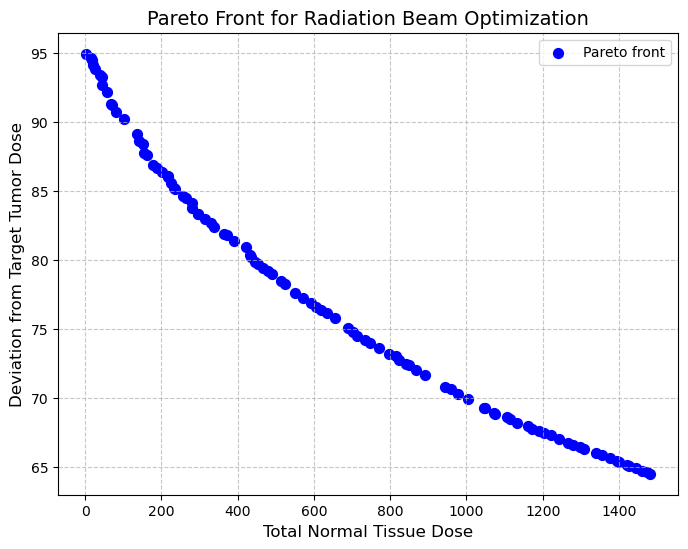

In [ ]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
import numpy as np

class BeamOptimizationProblem(Problem):
    def __init__(self, intensity_matrix, tumor_voxels, normal_voxels, max_beam_weight, minimum_tumor_dose=9.8, maximum_tumor_dose=10.2):
        self.intensity_matrix = intensity_matrix
        self.tumor_voxels = tumor_voxels
        self.normal_voxels = normal_voxels
        self.num_beams = intensity_matrix.shape[0]
        self.max_beam_weight = max_beam_weight
        self.minimum_tumor_dose = minimum_tumor_dose
        self.maximum_tumor_dose = maximum_tumor_dose

        # Problem definition: Multi-objective
        super().__init__(n_var=self.num_beams,
                         n_obj=2,  # Two objectives: minimize normal dose, minimize tumor dose deviation
                         n_constr=0,  # No explicit constraints here; constraints can be modeled as penalties
                         xl=0.0,  # Lower bound for beam weights
                         xu=max_beam_weight)  # Upper bound for beam weights

    def _evaluate(self, x, out, *args, **kwargs):
        # Ensure x is 2D (samples, num_beams)
        if x.ndim == 1:
            x = x[np.newaxis, :]

        # Calculate normal tissue dose for each sample
        normal_doses = np.sum(self.intensity_matrix[:, self.normal_voxels], axis=1)
        f1 = np.dot(x, normal_doses)  # Shape: (num_samples,)

        # Calculate tumor dose deviation for each sample
        tumor_doses = np.dot(self.intensity_matrix[:, self.tumor_voxels].T, x.T).T  # Shape: (num_samples, num_tumor_voxels)
        target_dose = (self.minimum_tumor_dose + self.maximum_tumor_dose) / 2
        f2 = np.mean((tumor_doses - target_dose) ** 2, axis=1)  # Shape: (num_samples,)

        # Assign objectives
        out["F"] = np.column_stack([f1, f2])  # Shape: (num_samples, 2)

# Example Usage
def solve_beam_optimization_pareto(
    intensity_matrix,
    tumor_voxels,
    normal_voxels,
    max_beam_weight=1,
):
    problem = BeamOptimizationProblem(intensity_matrix, tumor_voxels, normal_voxels, max_beam_weight)

    # Define the algorithm
    algorithm = NSGA2(pop_size=100)

    # Solve the problem
    res = minimize(problem,
                   algorithm,
                   ('n_gen', 200),  # Number of generations
                   verbose=True,
                   seed=1)

    return res

# Example data (replace with real values)
# intensity_matrix: 2D array of size (num_beams, num_voxels)
# tumor_voxels and normal_voxels: indices of tumor and normal tissue voxels
res = solve_beam_optimization_pareto(
    intensity_matrix=intensity_matrix,
    tumor_voxels=tumor_voxels,
    normal_voxels=normal_voxels,
    max_beam_weight=1,
)

# Extract results
pareto_front = res.F  # Objective values for Pareto-optimal solutions
pareto_solutions = res.X  # Corresponding decision variable values (beam weights)

# Extract Pareto-optimal solutions
pareto_weights = res.X  # Beam weights
pareto_objectives = res.F  # Corresponding objective values

# Display the Pareto front
print("Pareto-optimal solutions (weights):")
print(pareto_weights)
print("Pareto front (objective values):")
print(pareto_objectives)

# Plot Pareto front
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(pareto_objectives[:, 0], pareto_objectives[:, 1], c="blue", label="Pareto front", s=50)
plt.xlabel("Total Normal Tissue Dose", fontsize=12)
plt.ylabel("Deviation from Target Tumor Dose", fontsize=12)
plt.title("Pareto Front for Radiation Beam Optimization", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()
